## Cheking MBHB glitch and choosing MBHB params

In [6]:
# importing the needed modules

### importing modules

import numpy as np
import os, sys, re
import time

# from LISAhdf5 import LISAhdf5,ParsUnits
import tdi

import h5py
import ldc
import ldc.io.hdf5 as hdf5io

from ldc.common import constants
YRSID_SI = constants.Nature.SIDEREALYEAR_J2000DAY*24*60*60
MTsun = constants.Nature.SUN_GM/constants.Nature.VELOCITYOFLIGHT_CONSTANT_VACUUM**3

from astropy import units as un

# from ldc.waveform.lisabeta import FastMBHB
from ldc.lisa import orbits
from ldc.lisa.projection import ProjectedStrain
from ldc.waveform.waveform import HpHc
from ldc.common.series import TimeSeries, FrequencySeries
from ldc.common import tools


from ldc.lisa.noise import get_noise_model

# plotting

import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use(['seaborn-ticks','seaborn-deep'])

# %pylab inline

mpl.rcParams.update({'font.size': 16})
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (12,7)

%load_ext autoreload
%autoreload 2


### Try to read the glitch data file

In [2]:
fl_gl = '/Users/stas/Projects/LISA/Spritz/tdi_3smooth_glitch.h5'
fl_gl2 = '/Users/stas/Projects/LISA/Spritz/tdi_1long_glitch.h5'

f = h5py.File(fl_gl, 'r')

In [3]:
print (f['t'])
print (f.keys())

<HDF5 dataset "t": shape (518400,), type "<f8">
<KeysViewHDF5 ['X', 'Y', 'Z', 't']>


In [4]:
tm =  hdf5io.load_array(fl_gl, name="t")[0]
print ('time', tm)
X_glitch = hdf5io.load_array(fl_gl, name="X")[0]
print ('X', X_glitch)

X_glitch2 = hdf5io.load_array(fl_gl2, name="X")[0]

conf = hdf5io.load_config(fl_gl, name='/')
print ('conf', conf)

conf_long = hdf5io.load_config(fl_gl2, name='/')
print ('long glitch', conf_long)

time [0.000000e+00 5.000000e+00 1.000000e+01 ... 2.591985e+06 2.591990e+06
 2.591995e+06]
X [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.23709803e-23
 -4.75750049e-23  1.60481547e-22]
conf {'dataset info': '30 days dataset with 3 smooth step glitch injections on tm_12. TDI generation 2.0 produced with pytdi.', 'dt': 5.0, 'duration': 2592000, 'glitch 1 injection point': 'tm_12', 'glitch 1 injection time': 691200, 'glitch 2 injection point': 'tm_12', 'glitch 2 injection time': 1555200, 'glitch 3 injection point': 'tm_12', 'glitch 3 injection time': 1900800, 'size': 518400.0}
long glitch {'dataset info': '30 days dataset with 1 ~5h long glitch injection on tm_12. TDI generation 2.0 produced with pytdi.', 'dt': 5.0, 'duration': 2592000, 'glitch 1 injection point': 'tm_12', 'glitch 1 injection time': 691200, 'size': 518400.0}


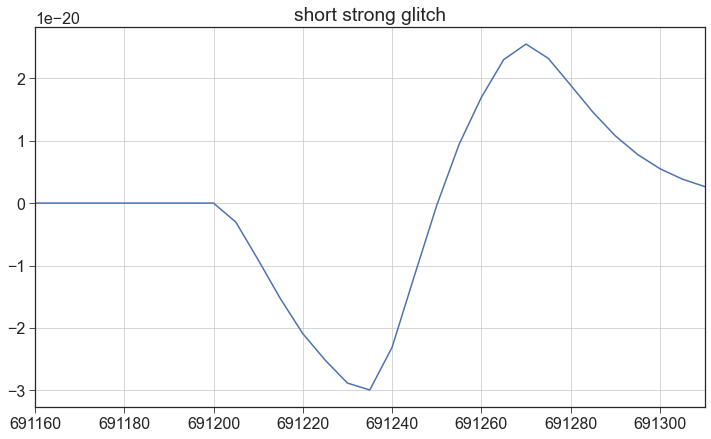

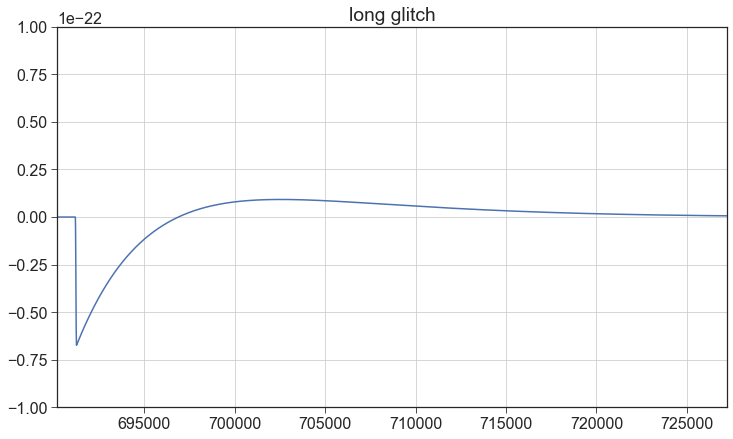

In [7]:

plt.title('short strong glitch')
plt.plot(tm, X_glitch)
plt.grid(True)
plt.xlim(conf['glitch 1 injection time']-40.0, conf['glitch 1 injection time']+110.0)
plt.show()

plt.title('long glitch')
plt.plot(tm, X_glitch2)
plt.grid(True)
plt.xlim(conf_long['glitch 1 injection time']-1000.0, conf_long['glitch 1 injection time']+10*3600)
plt.ylim(-1.e-22, 1.e-22)
plt.show()

### read MBHB params from Sangria training data set

In [7]:
h5file = '/Users/stas/Projects/LISA/Sangria/Data/LDC2_sangria_training_v1.h5'
MBHB_h5file = '/Users/stas/Projects/LISA/Sangria/Data/LDC2_sangria_mbhb-tdi_v1.h5'

MBHBpars = hdf5io.load_array(h5file, name="sky/mbhb/cat")

MBHBtdis = hdf5io.load_array(MBHB_h5file)

GWconf  = hdf5io.load_config(h5file, name='obs/config')

tc [11526944.92187926 11258573.77520055 16532191.54787011 29516089.74000174
 18605758.10777253 11167843.44201625  8746488.46859908 17245156.0022781
 24408761.95540857 20426222.35914461 23439839.1377948  11970964.48272545
 22228067.56520132  4800021.15572853 13617113.10218553]


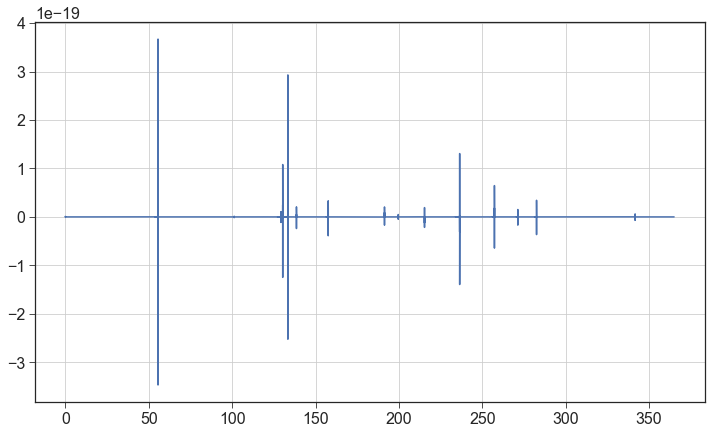

[0.0000000e+00 5.0000000e+00 1.0000000e+01 ... 3.1535990e+07 3.1535995e+07
 3.1536000e+07]


In [8]:
print ('tc', MBHBpars[0]['CoalescenceTime'])
# print (MBHBpars)
day = 24.0*3600.
plt.plot(MBHBtdis[0]['X'][:,0]/day, MBHBtdis[0]['X'][:,1], label="MBHBs")
plt.show()
tmMBHB = MBHBtdis[0]['X'][2:,0]
print (tmMBHB)
X_mbhb = MBHBtdis[0]['X'][2:,1]

In [9]:
print (518400*5.0/day)

TDI2=True

30.0


In [10]:
def semi_fast_tdi(orbits, pMBHB, t_max, dt):
    hphc = HpHc.type("MBHB", "MBHB", "IMRPhenomD")
    hphc.set_param(pMBHB)
    P = ProjectedStrain(orbits)    
    yArm = P.arm_response(0, t_max, dt, [hphc], tt_order=0)
    X = P.compute_tdi_x(np.arange(0, t_max, dt), tdi2=TDI2)
    Z = P.compute_tdi_z(np.arange(0, t_max, dt), tdi2=TDI2)
    Y = P.compute_tdi_y(np.arange(0, t_max, dt), tdi2=TDI2)
    return TimeSeries(X, dt=dt), TimeSeries(Y, dt=dt), TimeSeries(Z, dt=dt)

### Generating MBHB signals one after another

In [11]:
# from  ComputeMBHBXYZ_FD import ComputeMBHBXYZ_FD
# from LISAhdf5 import ParsUnits
from astropy.cosmology import FlatLambdaCDM
ldc_cosmo = FlatLambdaCDM(H0=67.1, Om0=0.3175)

lisa_orbits = orbits.Orbits.type(dict({"nominal_arm_length":2.5e9*un.m,
                                       "initial_rotation":0*un.rad,
                                       "initial_position":0*un.rad,
                                       "orbit_type":"analytic"}))


mbhb_fast = []
mbhb_cat = []
print (GWconf)
print ("Tmax= ", GWconf['t_max'].value)

for j,s in enumerate(MBHBpars[0]):
    print("Computing mbhb fast approx #%d"%j)
    s1 = dict(zip(MBHBpars[0].dtype.names, s)) 
    s1["ObservationDuration"] = GWconf['t_max'].value
    s1['Cadence'] = 5.0
#     s1['Distance'] = s1['Distance']*1.e-3
    expected_dl = ldc_cosmo.luminosity_distance(s1['Redshift'])* un.Mpc
    print ('DL', s1['Distance'], expected_dl, s1['Redshift'])

    
    
    psi, incl = tools.aziPolAngleL2PsiIncl(s1["EclipticLatitude"],
                                        s1["EclipticLongitude"],
                                        s1['InitialPolarAngleL'],
                                        s1['InitialAzimuthalAngleL'])
    s1['Polarization'] = psi
    s1['Inclination'] = incl
#     print ('s = \n', s1)
    ### using lisabeta
#     phenomD = FastMBHB(approx="IMRPhenomD", T=s1["ObservationDuration"], delta_t=s1['Cadence'], orbits=lisa_orbits)
#     A1, E1, T1 = phenomD.get_td_tdiaet(template=s1)
    ### Maude's interpolation module
    
    tc = s1['CoalescenceTime']
    print ('tc= ', tc, s1['CoalescenceTime']/day)
    
    X2, Y2, Z2 = semi_fast_tdi(lisa_orbits, s1, s1["ObservationDuration"], s1['Cadence'])
    
    mbhb_cat.append(s1)
    mbhb_fast.append(X2)
    
#     X2.plot(label='LDC')
#     plt.xlim(tc-30*day, tc+day)
#     plt.show()
    
    
    


    
    
    
    
    


#     break
    
#     pGW = ParsUnits(pars_i=dict(zip(MBHBpars[0].dtype.names, s)), units_i=units)
#     print ('pGW',  dict(zip(MBHBpars[0].dtype.names, s)))
#     fr, X, Y, Z = ComputeMBHBXYZ_FD(pGW)
#     mbhb_fast[j] = np.rec.fromarrays([fr, X, Y, Z], names=["freq", "X", "Y", "Z"])

{'accnoise': 2.4e-15, 'dirname': 'run2', 'dt': <Quantity 3. s>, 'initial_position': <Quantity 0. rad>, 'initial_rotation': <Quantity 0. rad>, 'interp_order': 3, 'ldc_liborbits': '/codes/LDC/ldc/lisa/orbits', 'nbatch': 1, 'nominal_arm_length': <Quantity 2.5e+09 m>, 'opticalnoise': 5e-12, 'orbit_type': 'analytic', 'readoutnoise': 6.35e-12, 't_max': <Quantity 31536000. s>, 't_min': <Quantity 0. s>, 'travel_time_order': 1}
Tmax=  31536000.0
Computing mbhb fast approx #0
DL 13470.983558972537 13470.98355897254 Mpc2 1.73941
tc=  11526944.921879262 133.41371437360257
Computing mbhb fast approx #1
DL 7705.852640407434 7705.852640407443 Mpc2 1.10396
tc=  11258573.775200551 130.307566842599
Computing mbhb fast approx #2
DL 43010.925050110134 43010.925050109996 Mpc2 4.57261
tc=  16532191.547870105 191.3448095818299
Computing mbhb fast approx #3
DL 83307.07617964421 83307.07617964414 Mpc2 8.08487
tc=  29516089.740001738 341.6214090277979
Computing mbhb fast approx #4
DL 73048.16721769486 73048.167

15
0


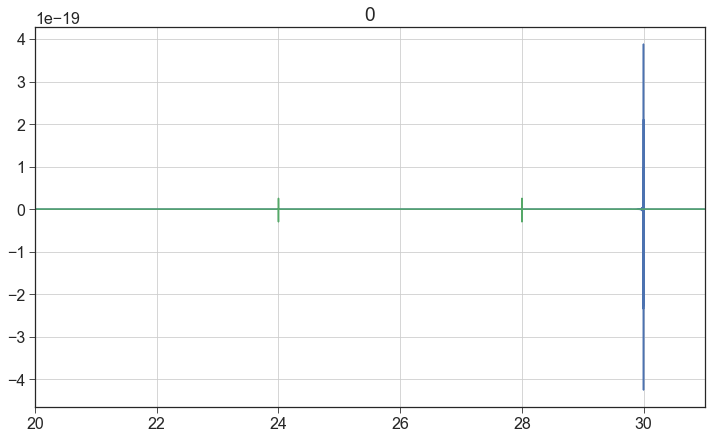

1


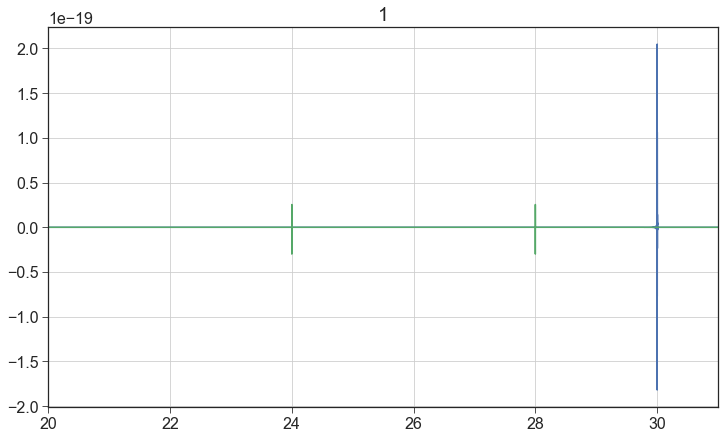

2


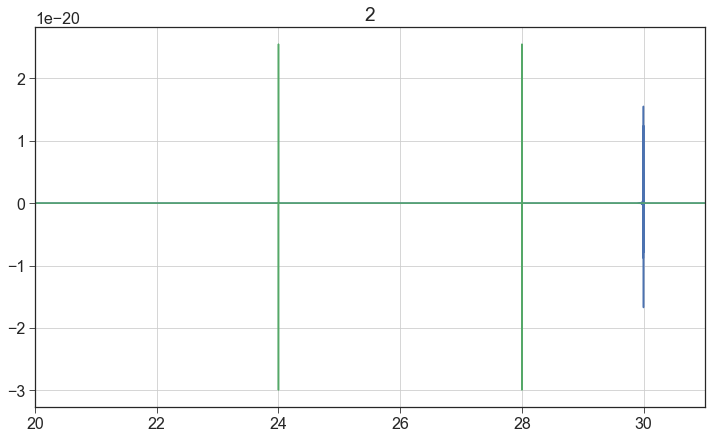

3


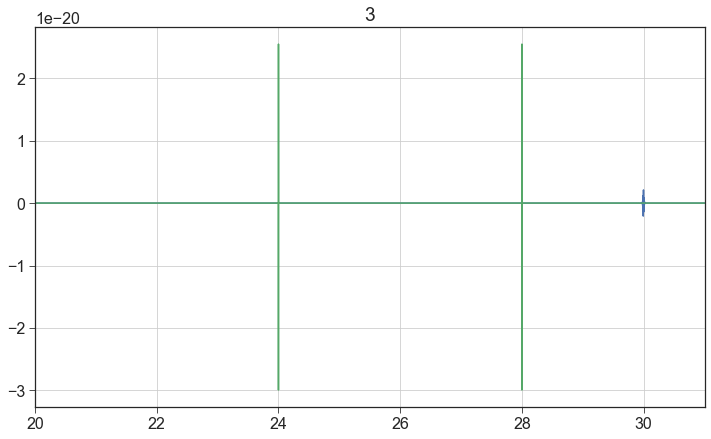

4


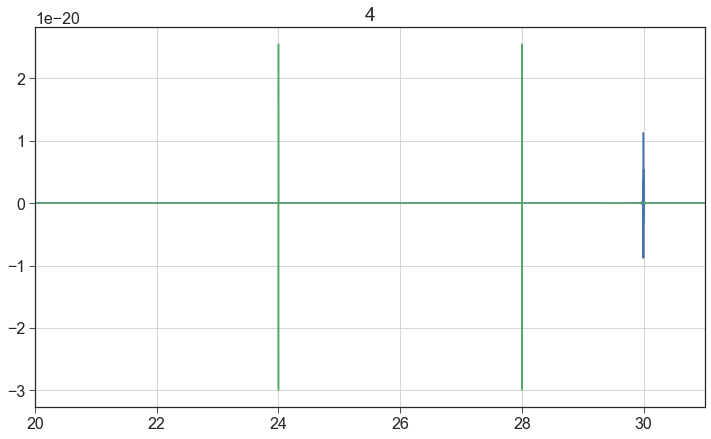

5


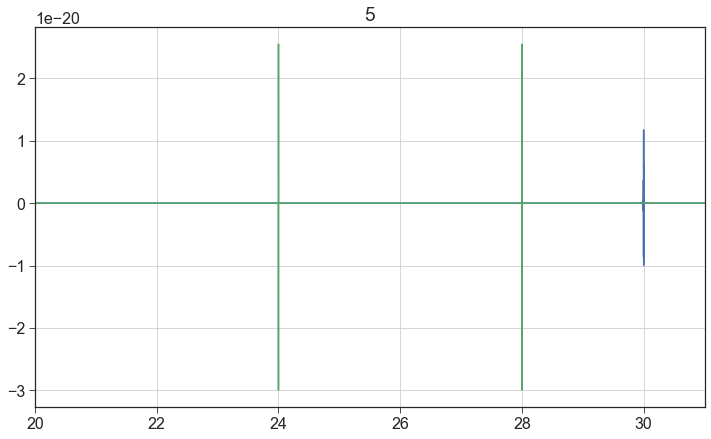

6


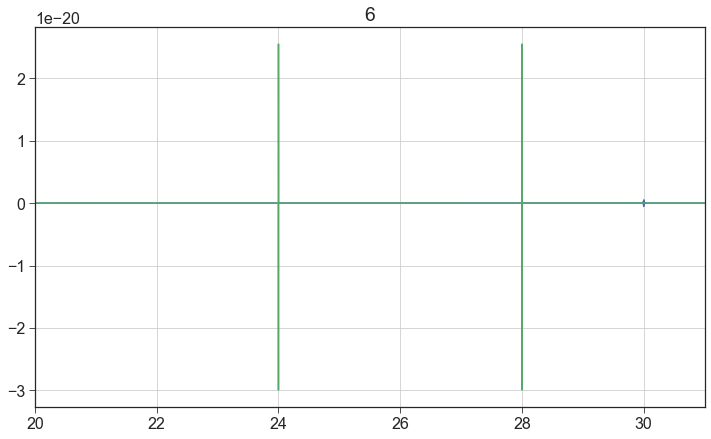

7


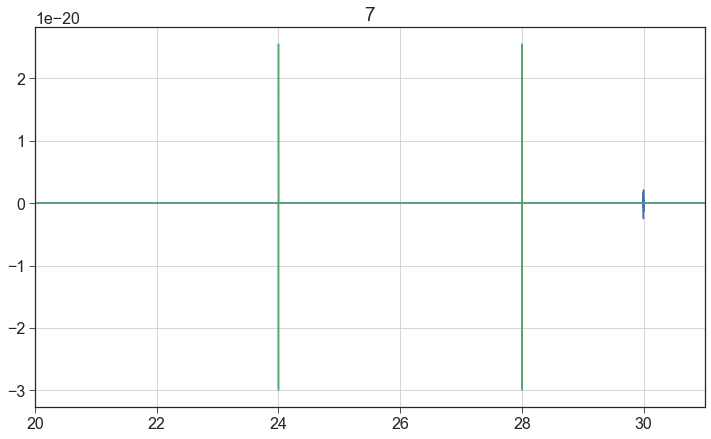

8


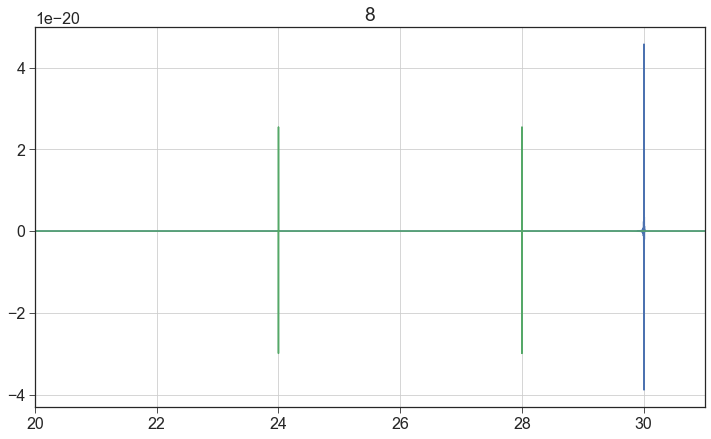

9


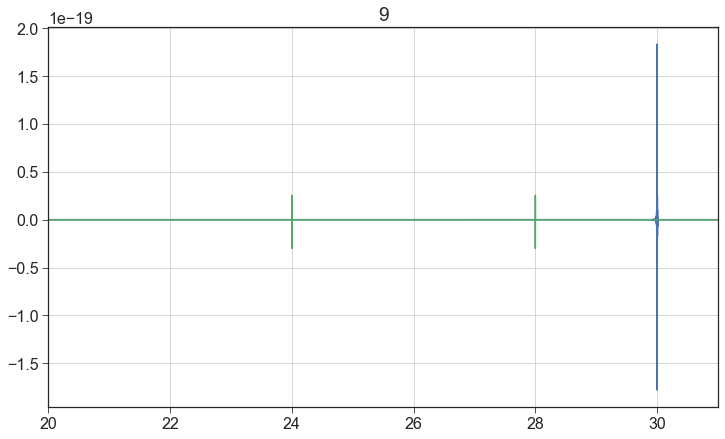

10


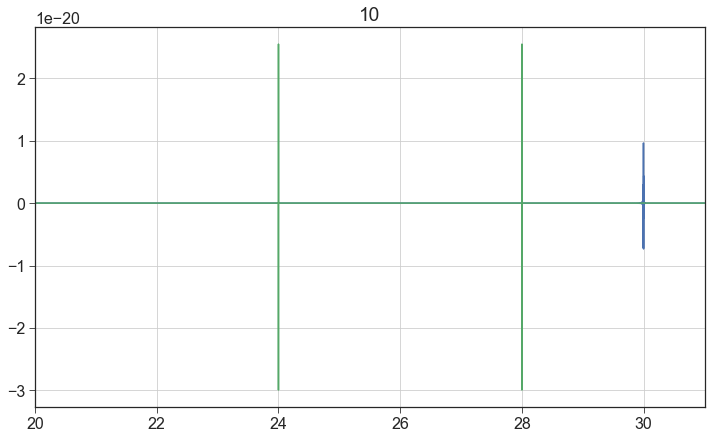

11


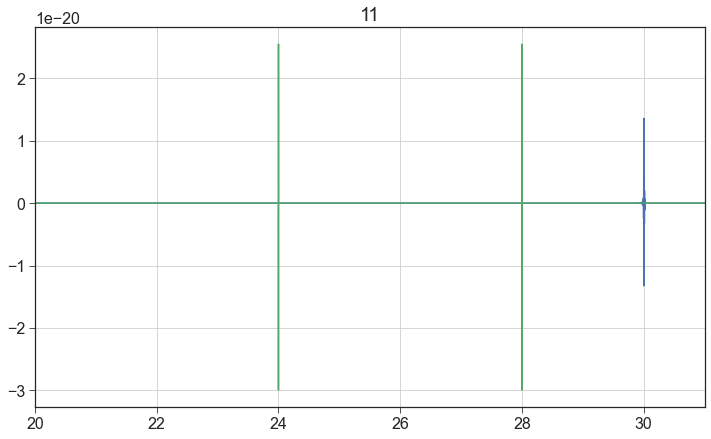

12


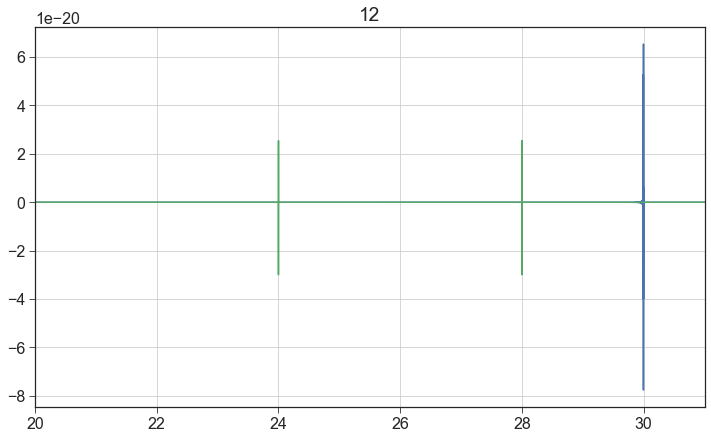

13


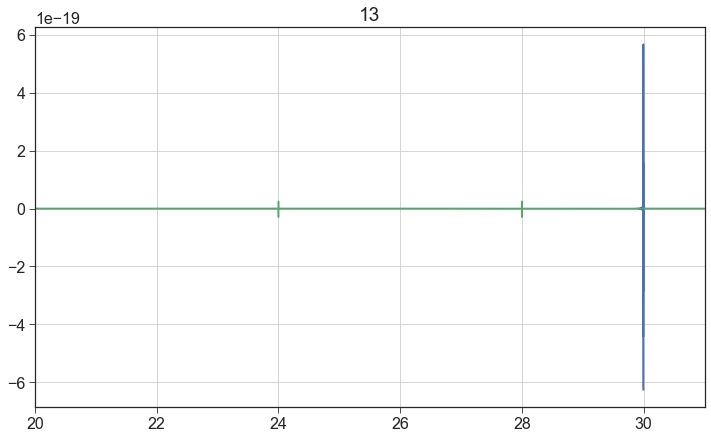

14


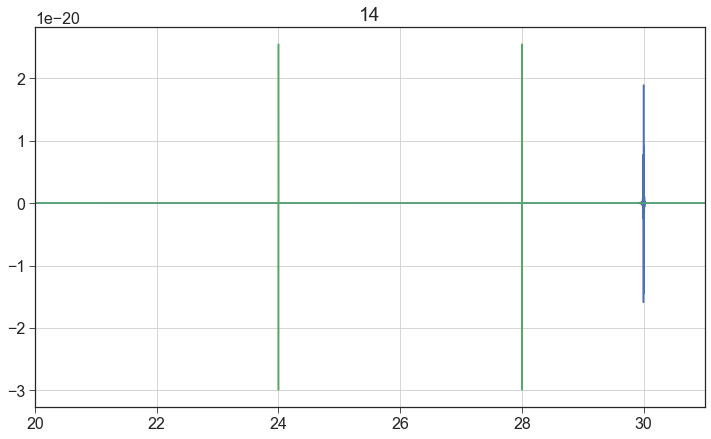

{'EclipticLatitude': -0.9873035001010817, 'EclipticLongitude': 3.886726441488628, 'PolarAngleOfSpin1': 2.5943393218569093, 'PolarAngleOfSpin2': 1.7194460407742886, 'Spin1': 0.829141, 'Spin2': 0.972219, 'Mass1': 3204750.46674, 'Mass2': 3056613.4089599997, 'CoalescenceTime': 13617113.102185527, 'PhaseAtCoalescence': 3.6286824771238195, 'InitialPolarAngleL': 2.0509277192961766, 'InitialAzimuthalAngleL': 1.0843698722336905, 'Redshift': 2.87966, 'Distance': 24829.1377752024, 'ObservationDuration': 31536000.0, 'Cadence': 5.0, 'Polarization': -1.2703116060085176, 'Inclination': 1.495395967779582}


In [12]:
Ncat = len(mbhb_cat)
print (Ncat)



for ii in range(Ncat):
    print (ii)
    pars = mbhb_cat[ii]
    tc = pars['CoalescenceTime']
#     print ('tc = ', tc)
    X = mbhb_fast[ii]
    
#     print (X['t'].values)
#     print (X.values)
    plt.title(str(ii))
    plt.plot((X['t'].values - tc + 30*day)/day, X.values)
    plt.plot(tm/day+6., X_glitch)
    plt.xlim(20, 31)
#     plt.ylim(-2.e-20, 2.e-20)
    plt.show()
#     break

print (pars)

# Compute SNR

In [13]:
import lisabeta
import lisabeta.lisa.lisa as lisa
import lisabeta.lisa.pyresponse as pyresponse

Tobs = s1["ObservationDuration"] 
dt = s1['Cadence']
df = 1.0/Tobs
 

# waveform_params = {
#     "minf": 1e-5,
#     "maxf": 0.5,
#     "timetomerger_max": 1.0,
#     "fend": None,
#     "tmin": None,
#     "tmax": None,
#     "TDI": "TDIAET",
#     "acc": 1e-4,
#     "order_fresnel_stencil": 0,
#     "approximant": "IMRPhenomD",
#     "LISAconst": "Proposal",
#     "responseapprox": "full",
#     "frozenLISA": False,
#     "TDIrescaled": True,
#     "LISAnoise": {
#       "InstrumentalNoise": "SciRDv1",
#       "WDbackground": False,
#       "WDduration" : 0.
#     }
#   }


waveform_params = {
            "minf": 1e-5,  "maxf": 0.1,
            "timetomerger_max": 1.0,
            "fend": None, "tmin": None, "tmax": None,
            "TDI": "TDIAET", "acc": 1e-4,
            "order_fresnel_stencil": 0,
            "approximant": 'IMRPhenomD',
            "LISAconst": pyresponse.LISAconstDict["Proposal"],
            "responseapprox": "full",
            "frozenLISA": False,
            "TDIrescaled": False
        }


def MakeSMBH(p):
    s_params={
        "m1": p['Mass1'],
        "m2": p['Mass2'],
        "chi1": p['Spin1']*np.cos(p['PolarAngleOfSpin1']),
        "chi2": p['Spin1']*np.cos(p['PolarAngleOfSpin1']),
        "Deltat": 0.0,
        "dist": p['Distance'],
        "inc": p['Inclination'],
        "phi": p['PhaseAtCoalescence'],
        "lambda": p['EclipticLongitude'],
        "beta": p['EclipticLatitude'],
        "psi": p['Polarization']
    }
    waveform_params['t0'] = p['CoalescenceTime']
#     waveform_params['TDI'] = 'TDIXYZ'
    
    sig  = lisa.GenerateLISATDISignal_SMBH(s_params, **waveform_params)
    md = (2,2)
    rq = sig['tdi'][md]['freq']
    df = 1/Tobs
    freqs = np.arange(0, 0.1, df)
    
    tdifreqseries = lisa.EvaluateTDIFreqseries(sig["tdi"], freqs)

    A = tdifreqseries[md]['chan1']
    E = tdifreqseries[md]['chan2']
    T = tdifreqseries[md]['chan3']

    Af = FrequencySeries(np.conj(A), df=df, name="A")
    Ef = FrequencySeries(np.conj(E), df=df, name="E")
    Tf = FrequencySeries(np.conj(T), df=df, name="T")
    
    At = Af.ts.ifft(dt=dt)
    Et = Ef.ts.ifft(dt=dt)
    Tt = Tf.ts.ifft(dt=dt)
    
    
    return At,Et,Tt



In [14]:
ind = 0
pars = mbhb_cat[ind]
print (pars)

Alb, Ylb, Tlb = MakeSMBH(pars)

{'EclipticLatitude': -0.30300442294174235, 'EclipticLongitude': 1.2925183861048521, 'PolarAngleOfSpin1': 1.2031361791056812, 'PolarAngleOfSpin2': 2.097303543065685, 'Spin1': 0.747377, 'Spin2': 0.8388, 'Mass1': 1323277.47932, 'Mass2': 612485.5060299999, 'CoalescenceTime': 11526944.921879262, 'PhaseAtCoalescence': 1.2201968860015653, 'InitialPolarAngleL': 2.6919824500032945, 'InitialAzimuthalAngleL': 1.808398497592109, 'Redshift': 1.73941, 'Distance': 13470.983558972537, 'ObservationDuration': 31536000.0, 'Cadence': 5.0, 'Polarization': -1.8503700516659007, 'Inclination': 2.2517895222056112}


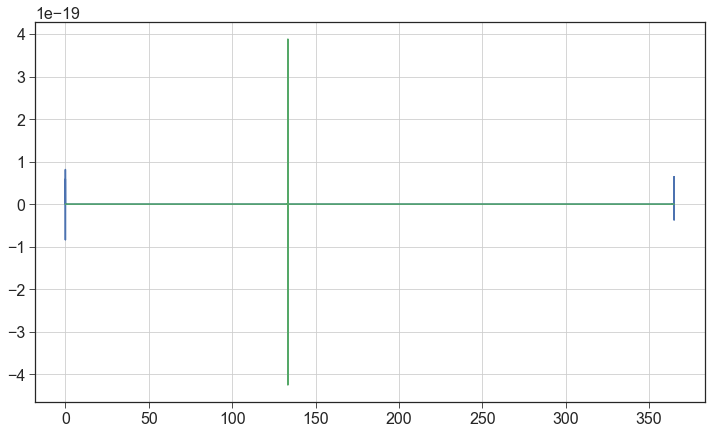

In [15]:
X = mbhb_fast[ind]
plt.plot(np.arange(len(Alb))*dt/day, Alb)
plt.plot(X['t'].values/day, X.values)
plt.show()

In [16]:
def AET(X,Y,Z):
    return ((Z - X)/np.sqrt(2.0),
            (X - 2.0*Y + Z)/np.sqrt(6.0),
            (X + Y + Z)/np.sqrt(3.0))


def semi_fast_tdi(orbits, pMBHB, t_max, dt):
    hphc = HpHc.type("MBHB", "MBHB", "IMRPhenomD")
    hphc.set_param(pMBHB)
    P = ProjectedStrain(orbits)    
    yArm = P.arm_response(0, t_max, dt, [hphc], tt_order=0)
    X = P.compute_tdi_x(np.arange(0, t_max, dt))
    Z = P.compute_tdi_z(np.arange(0, t_max, dt))
    Y = P.compute_tdi_y(np.arange(0, t_max, dt))
    return TimeSeries(X, dt=dt), TimeSeries(Y, dt=dt), TimeSeries(Z, dt=dt)


lisa_orbits = orbits.Orbits.type(dict({"nominal_arm_length":2.5e9*un.m,
                                       "initial_rotation":0*un.rad,
                                       "initial_position":0*un.rad,
                                       "orbit_type":"analytic"}))
params_2 = mbhb_cat[ind]

In [17]:
params_1 = params_2.copy()
psi, incl = tools.aziPolAngleL2PsiIncl(params_2["EclipticLatitude"],
                                       params_2["EclipticLongitude"],
                                       params_2['InitialPolarAngleL'],
                                       params_2['InitialAzimuthalAngleL'])
params_1['Polarization'] = psi
params_1['Inclination'] = incl
params_1["Spin1"] = params_2['Spin1']*np.cos(params_2['PolarAngleOfSpin1'])
params_1["Spin2"] = params_2['Spin2']*np.cos(params_2['PolarAngleOfSpin2'])
params_1.pop('PolarAngleOfSpin1')
params_1.pop('PolarAngleOfSpin2')
params_1.pop('InitialPolarAngleL')
params_1.pop('InitialAzimuthalAngleL')
params_1.pop('ObservationDuration')
params_1.pop('Cadence')
params_1.pop('Redshift')


1.73941

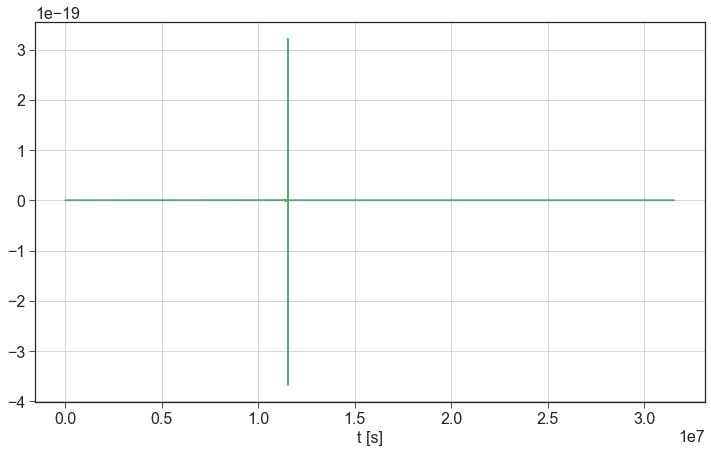

In [18]:
X2, Y2, Z2 = semi_fast_tdi(lisa_orbits, params_2, Tobs, dt)
A2, E2, T2 = AET(X2,Y2,Z2)

phenomD = FastMBHB(approx="IMRPhenomD", T=Tobs, delta_t=dt, orbits=lisa_orbits)
A1, E1, T1 = phenomD.get_td_tdiaet(template=params_1)

A1.plot(label="lisabeta")
A2.plot(label='LDC')
plt.grid(True)
plt.show()


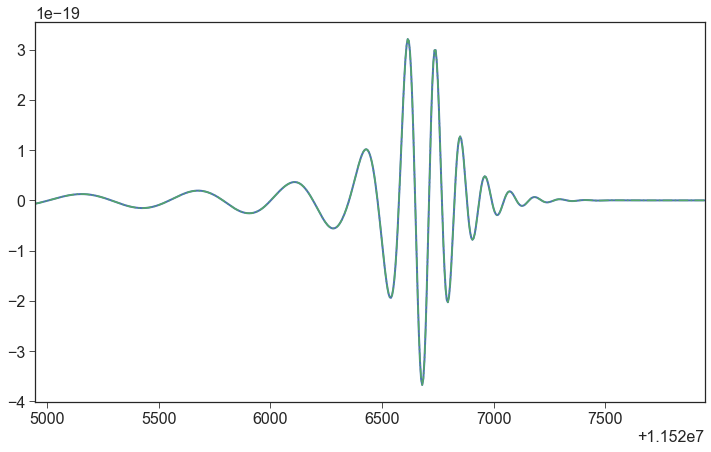

<xarray.DataArray 'A' (t: 6307200)>
array([-1.11419745e-24, -1.11049617e-24, -1.10687416e-24, ...,
       -1.12524805e-24, -1.12163121e-24, -1.11793024e-24])
Coordinates:
  * t        (t) float64 0.0 5.0 10.0 15.0 ... 3.154e+07 3.154e+07 3.154e+07
Attributes:
    units:    None
    t0:       0
    dt:       5.0
<xarray.DataArray (t: 6307200)>
array([-1.09005699e-24, -1.08666500e-24, -1.08325470e-24, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])
Coordinates:
  * t        (t) float64 0.0 5.0 10.0 15.0 ... 3.154e+07 3.154e+07 3.154e+07


In [19]:
plt.plot(A1['t'].values, A1.values, lw=2)
plt.plot(A2['t'].values, A2.values, '-.')
plt.xlim(params_2['CoalescenceTime']-2000, params_2['CoalescenceTime']+1000)
plt.grid()
plt.show()
print (A1)
print (A2)

In [21]:
def rename(params_i):
    params = params_i.copy()
    if 'PolarAngleOfSpin1' in params.keys():
        psi, incl = tools.aziPolAngleL2PsiIncl(params["EclipticLatitude"],
                                                params["EclipticLongitude"],
                                                params['InitialPolarAngleL'],
                                                params['InitialAzimuthalAngleL'])
        params['Polarization'] = psi
        params['Inclination'] = incl
        params["Spin1"] = params['Spin1']*np.cos(params['PolarAngleOfSpin1'])
        params["Spin2"] = params['Spin2']*np.cos(params['PolarAngleOfSpin2'])
        for k in ['PolarAngleOfSpin1', 'PolarAngleOfSpin2', 'InitialPolarAngleL',
                      'InitialAzimuthalAngleL', 'ObservationDuration', 'Cadence', 'Redshift']:
            params.pop(k)

    dmatch = dict({'EclipticLatitude':"beta", 'EclipticLongitude':"lambda",
                       'Spin1':"chi1", 'Spin2':"chi2",
                       'Mass1':"m1", 'Mass2':"m2",
                       'CoalescenceTime':'Deltat', 'PhaseAtCoalescence':'phi',
                       'Polarization':'psi', 'Inclination':'inc', 'Distance':'dist'})
    new_params = dict()
    if isinstance(params, dict):
        for k,v in params.items():
            new_params[dmatch[k]] = params[k]
    else:
        new_params = rfn.rename_fields(params, dmatch)
    return new_params
    
pars1 = rename(params_1)

print (pars1)
    

cumulsnr = lisa.CumulSNRLISATDI_SMBH(pars1, **waveform_params)
# print (cumulsnr['tf'], params_1['CoalescenceTime'])
print (cumulsnr.keys())
print (cumulsnr['SNRcumul'][-1], cumulsnr['SNR1cumul'][-1], cumulsnr['SNR2cumul'][-1])

{'beta': -0.30300442294174235, 'lambda': 1.2925183861048521, 'chi1': 0.26863190922667673, 'chi2': -0.4215109787709388, 'm1': 1323277.47932, 'm2': 612485.5060299999, 'Deltat': 11526944.921879262, 'phi': 1.2201968860015653, 'dist': 13470.983558972537, 'psi': -1.8503700516659007, 'inc': 2.2517895222056112}
dict_keys(['freq', 'tf', 'SNRcumul', 'SNR1cumul', 'SNR2cumul', 'SNR3cumul'])
3114.6087087568953 2147.7692505692817 2255.6202052491476


133.41371437360257


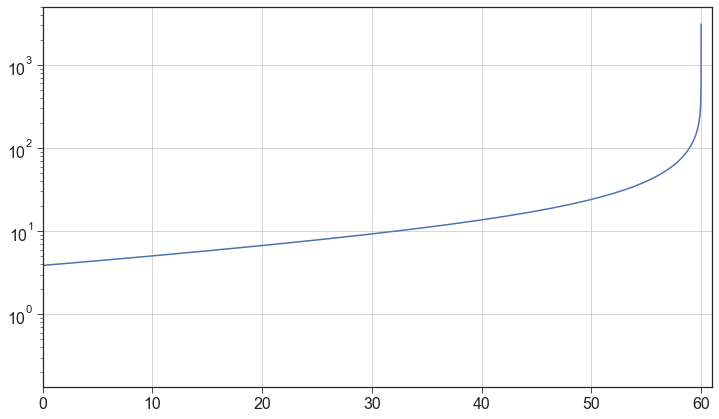

3114.6087087568953


In [23]:
print (params_1['CoalescenceTime']/day)
plt.semilogy((cumulsnr['tf'] - cumulsnr['tf'][-1])/day + 60., cumulsnr['SNRcumul'])
plt.xlim(0, 61)
# plt.grid()
plt.show()
print (cumulsnr['SNRcumul'][-1]) 

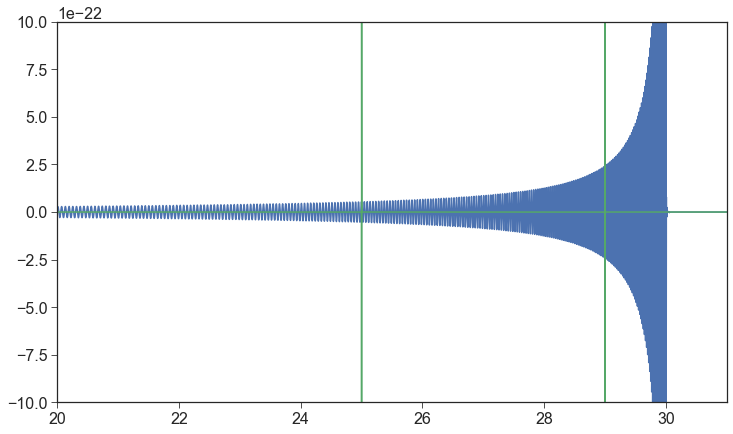

In [24]:
plt.plot((X2['t'].values - params_1['CoalescenceTime'])/day + 30, X2.values)
plt.plot(tm/day+7., X_glitch)
plt.xlim(20, 31)
# plt.ylim(-5.e-20, 5.e-20)
plt.ylim(-1.e-21, 1.e-21)
plt.grid()
plt.show()

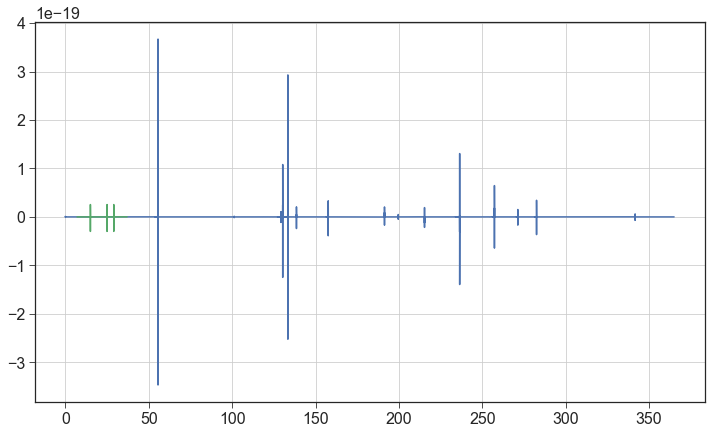

In [25]:
plt.plot(MBHBtdis[0]['X'][:,0]/day, MBHBtdis[0]['X'][:,1], label="MBHBs")
plt.plot(tm/day+7., X_glitch)
plt.show()

### THE CORRECT ONE




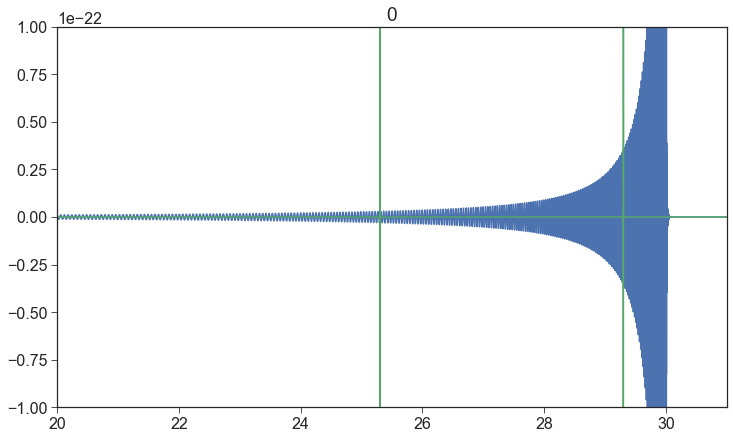

In [26]:

ind = 0

pars = mbhb_cat[ind]
tc = pars['CoalescenceTime']
#     print ('tc = ', tc)
X = mbhb_fast[ind]

X = mbhb_fast[ind]
    

plt.title(str(ind))
plt.plot((X['t'].values - tc + 30*day)/day, X.values)
plt.plot(tm/day+7.3, X_glitch)
plt.xlim(20, 31)
plt.ylim(-1.e-22, 1.e-22)
plt.grid()
plt.show()

8.0
tc= 101.23250542360047


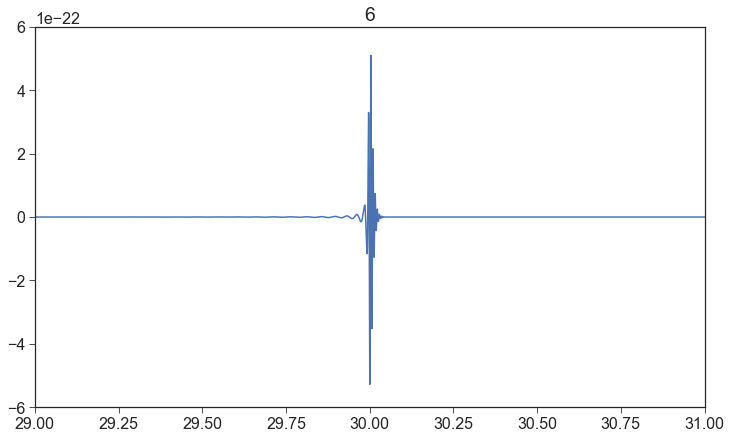

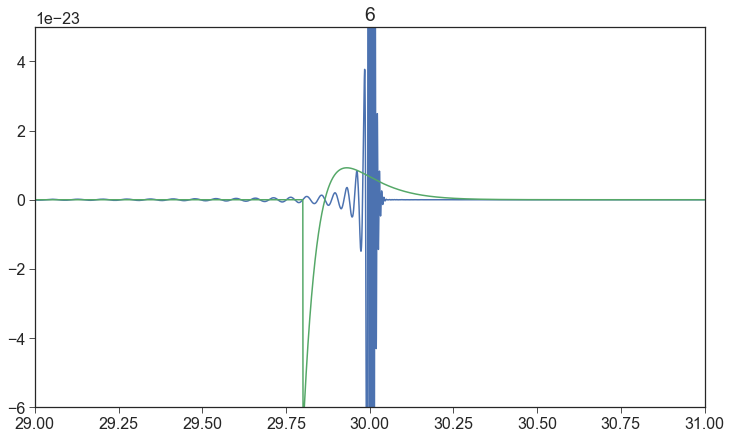

In [27]:

ind_l = 6

pars_l = mbhb_cat[ind_l]
tc = pars_l['CoalescenceTime']
#     print ('tc = ', tc)
X = mbhb_fast[ind_l]

tgl_l = conf_long['glitch 1 injection time']
print (tgl_l/day)

print ('tc=', tc/day)
plt.title(str(ind_l))
plt.plot((X['t'].values - tc + 30*day)/day, X.values)
# plt.plot(tm/day+21.8, X_glitch2)
plt.xlim(29, 31)
# # plt.ylim(-1.e-22, 1.e-22)
plt.ylim(-6.e-22, 6.e-22)
plt.grid()
plt.show()

plt.title(str(ind_l))
plt.plot((X['t'].values - tc + 30*day)/day, X.values)
# plt.plot((X['t'].values - tc + 30*day)/day, X.values)
plt.plot(tm/day+21.8, X_glitch2)
plt.xlim(29, 31)
# plt.ylim(-1.e-22, 1.e-22)
plt.ylim(-6.e-23, 5.e-23)
plt.grid()
plt.show()

In [28]:
def rename(params_i):
    params = params_i.copy()
    if 'PolarAngleOfSpin1' in params.keys():
        psi, incl = tools.aziPolAngleL2PsiIncl(params["EclipticLatitude"],
                                                params["EclipticLongitude"],
                                                params['InitialPolarAngleL'],
                                                params['InitialAzimuthalAngleL'])
        params['Polarization'] = psi
        params['Inclination'] = incl
        params["Spin1"] = params['Spin1']*np.cos(params['PolarAngleOfSpin1'])
        params["Spin2"] = params['Spin2']*np.cos(params['PolarAngleOfSpin2'])
        for k in ['PolarAngleOfSpin1', 'PolarAngleOfSpin2', 'InitialPolarAngleL',
                      'InitialAzimuthalAngleL', 'ObservationDuration', 'Cadence', 'Redshift']:
            params.pop(k)

    dmatch = dict({'EclipticLatitude':"beta", 'EclipticLongitude':"lambda",
                       'Spin1':"chi1", 'Spin2':"chi2",
                       'Mass1':"m1", 'Mass2':"m2",
                       'CoalescenceTime':'Deltat', 'PhaseAtCoalescence':'phi',
                       'Polarization':'psi', 'Inclination':'inc', 'Distance':'dist'})
    new_params = dict()
    if isinstance(params, dict):
        for k,v in params.items():
            new_params[dmatch[k]] = params[k]
    else:
        new_params = rfn.rename_fields(params, dmatch)
    return new_params
    


In [29]:
print (pars_l)

pars1_l = rename(pars_l)

print (pars1_l)
    

cumulsnr = lisa.CumulSNRLISATDI_SMBH(pars1_l, **waveform_params)

{'EclipticLatitude': -1.081082148175418, 'EclipticLongitude': 4.052962883461064, 'PolarAngleOfSpin1': 2.354231671039206, 'PolarAngleOfSpin2': 1.6897651680270387, 'Spin1': 0.742128, 'Spin2': 0.989247, 'Mass1': 4956676.287599999, 'Mass2': 4067166.60352, 'CoalescenceTime': 8746488.468599081, 'PhaseAtCoalescence': 3.783308916721985, 'InitialPolarAngleL': 0.9635860362638292, 'InitialAzimuthalAngleL': 3.6369245022627883, 'Redshift': 6.17688, 'Distance': 61097.11607589422, 'ObservationDuration': 31536000.0, 'Cadence': 5.0, 'Polarization': 1.2284435000811331, 'Inclination': 1.4200483407549194}
{'beta': -1.081082148175418, 'lambda': 4.052962883461064, 'chi1': -0.5237327147799223, 'chi2': -0.1174121441258431, 'm1': 4956676.287599999, 'm2': 4067166.60352, 'Deltat': 8746488.468599081, 'phi': 3.783308916721985, 'dist': 61097.11607589422, 'psi': 1.2284435000811331, 'inc': 1.4200483407549194}


101.23250542360047


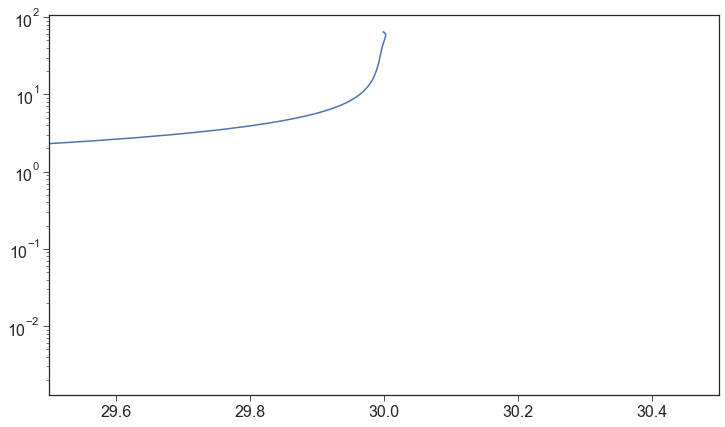

64.26290940826932


In [30]:
print (pars_l['CoalescenceTime']/day)
plt.semilogy((cumulsnr['tf'] - cumulsnr['tf'][-1])/day + 30., cumulsnr['SNRcumul'])
plt.xlim(29.5, 30.5)
plt.grid()
plt.show()
print (cumulsnr['SNRcumul'][-1]) 


### Compute SNR(t)

1. Chop the data 
2. COmpute SNR without glitch 
3. COmpute SNR with glitch

tc =  133.41371437360257
(1054080,)


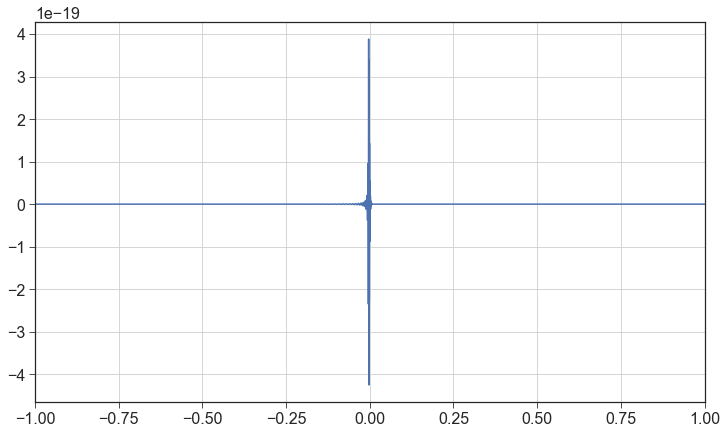

5270395.0
[0.00000000e+00 1.89739099e-07 3.79478199e-07 ... 9.99997154e-02
 9.99999051e-02 1.00000095e-01]
True


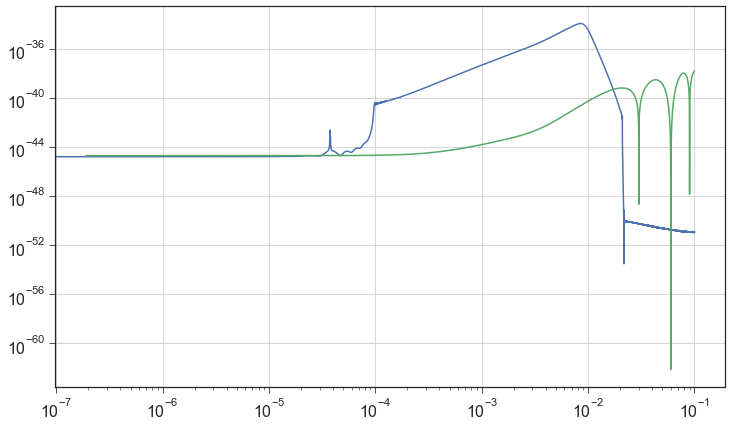

In [49]:
# print (plt.rcParams.keys())


ind = 0

X = mbhb_fast[ind]

pars = mbhb_cat[ind]
tc = pars['CoalescenceTime']
print ('tc = ', tc/day)

ind_s = np.argwhere(((X['t'].values - tc)/day >= -60.0) & ((X['t'].values - tc)/day <= 1.0))[:, 0]
print (np.shape(ind_s))

X_loud = X.values[ind_s]
tm_loud = X['t'].values[ind_s] - tc



# plt.plot(tm_loud/day, np.log(np.abs(X_loud)))
plt.plot(tm_loud/day, X_loud)
# plt.plot(X['t'].values[ind_s]/day, X.values[ind_s])
plt.xlim(-1,1)
plt.show()



Xf_loud = np.fft.rfft(X_loud)
T_loud = tm_loud[-1]-tm_loud[0]
print (T_loud)
fr = np.arange(len(Xf_loud))*(1.0/T_loud)


print (fr)

print (TDI2)
noise_model = "MRDv1"
# noise_model = "SciRDv1"
Nmodel = get_noise_model(noise_model, fr[1:])
Npsd = Nmodel.psd(fr[1:], option="X", tdi2=TDI2)

plt.loglog(fr, np.abs(Xf_loud)**2)
plt.loglog(fr[1:], Npsd)
# plt.ylim(1.e-45, 1.e-37)
plt.show()


(1054080,)
[ 0.00000000e+00  9.48694596e-07  1.89738919e-06 ... -2.84608379e-06
 -1.89738919e-06 -9.48694596e-07]
[0.00000000e+00 9.48694596e-07 1.89738919e-06 ... 4.99997154e-01
 4.99998103e-01 4.99999051e-01] [-5.00000000e-01 -4.99999051e-01 -4.99998103e-01 ... -2.84608379e-06
 -1.89738919e-06 -9.48694596e-07]
rho2= [4.04776120e-23+0.00000000e+00j 4.04777757e-23+4.53900986e-26j
 4.04782672e-23+9.07852520e-26j ... 4.04790832e-23-1.36184986e-25j
 4.04782672e-23-9.07852522e-26j 4.04777757e-23-4.53900990e-26j]
9.486945962355799e-07 (1054080,)
SN2 =  (7.3229100852215e-20+7.51112678311022e-32j)
(1054080,)
tst [6.94720523e-26+0.00000000e+00j 3.50302816e-26+1.33065903e-37j
 3.54493152e-26+1.22162911e-37j ... 3.58946341e-26-1.12628284e-37j
 3.54493152e-26+8.86591062e-39j 3.50302816e-26+1.96583903e-37j]


/Users/stas/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


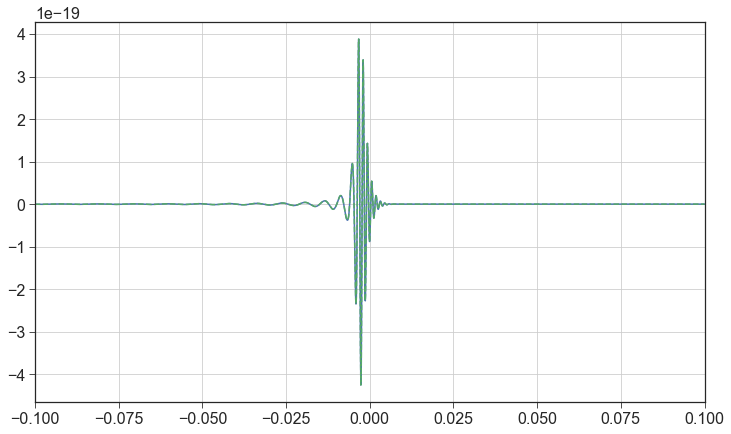

In [50]:
def SNRoft(fr, x, y, S):
    df = fr[2]-fr[1]
    rho2 = 4.*df*x, np.conjugate(y)/S
    print (np.shape(rho2))
    N = len(rho2)
    rho22 = np.zeros(2*N+1, dtype=np.complex128)
    rho22[0] = 0.0
    rho22[1:N+1] = np.copy(rho2)
    rho22[N+1:] = np.copy(np.flip(np.conjugate(rho2)))
    print ('SN2 = ', np.sum(rho2))
    return(np.fft.ifft(np.real(rho22)))


def SNRoft2(fr, x, y, S):
    df = fr[2]-fr[1]
#     rho2 = x*np.conjugate(y)/S
#     rho2 = rho2*2.*df
    rho2 = x
#     rho2 = x*np.conjugate(y)
    print ('rho2=', rho2)
    print (df, np.shape(rho2))
    print ('SN2 = ', np.sum(rho2))
    return(np.fft.ifft(np.real(rho2)))

Xf_loud = np.fft.fft(X_loud)
freq = np.fft.fftfreq(tm_loud.shape[-1])

print (Xf_loud.shape)
print (freq)
Nt = int(len(tm_loud)/2)
print (freq[:Nt], freq[Nt:])
Npsd = Nmodel.psd(freq[1:Nt], option="X", tdi2=TDI2)
S2sd = np.zeros(2*Nt)
S2sd[1:Nt] = np.copy(Npsd)
S2sd[Nt] = S2sd[Nt-1]
S2sd[0] = S2sd[1]
S2sd[Nt+1:] = np.copy(np.flip(Npsd))

tst = SNRoft2(freq, Xf_loud, Xf_loud, S2sd)

print (tst.shape)
print ('tst', tst)
del_t = tm_loud[1]-tm_loud[0]
# rho2 = SNRoft(fr[1:], Xf_loud[1:], Xf_loud[1:], Npsd)

# print (len(rho2), len(X_loud))
# print (rho2)

# # plt.plot(tm_loud[:len(rho2)], rho2)
# # plt.show()

# del_t = tm_loud[2]-tm_loud[1]
# print ('dt = ', del_t)
# # tt = np.arange(len(rho2))*2.*del_t
# tt = np.arange(len(rho2))*del_t
# plt.plot(tm_loud/day, np.abs(tst))
plt.plot(tm_loud/day, 2*tst)
plt.plot(tm_loud/day, X_loud, '--')
# plt.xlim(-59.1, -58.9)
plt.xlim(-1.e-1, 1.e-1)
plt.show()


### Drives me crazy. Let's try again

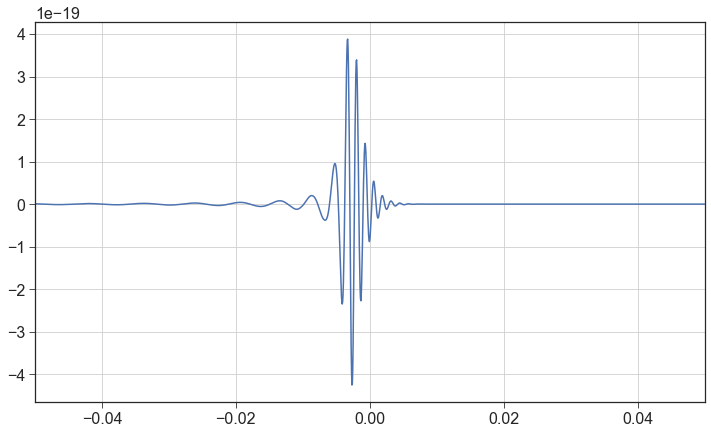

[0.00000000e+00 1.89739099e-07 3.79478199e-07 ... 9.99995257e-02
 9.99997154e-02 9.99999051e-02]


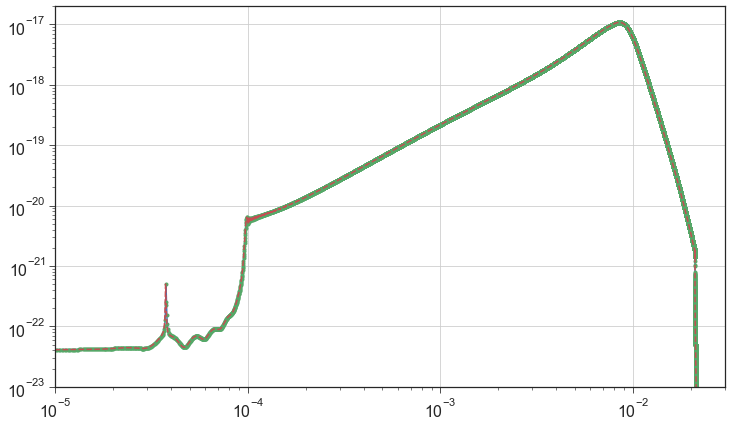

(1054080,) (1054080,) (1054080,)


/Users/stas/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


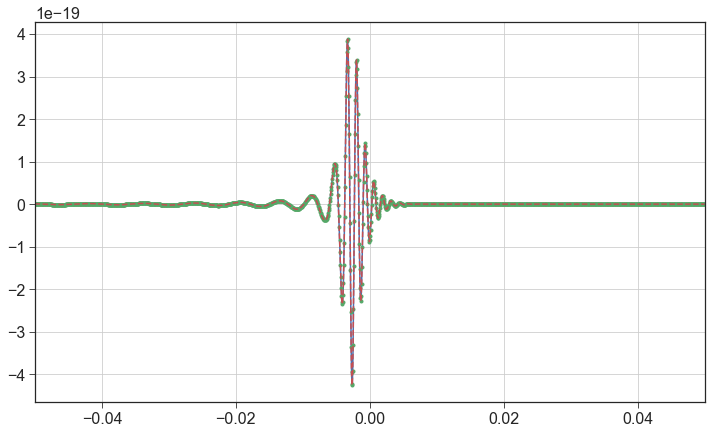

In [51]:
plt.plot(tm_loud/day, X_loud)
plt.xlim(-0.05, 0.05)
plt.show()

### real FFT:

Xf1 = np.fft.rfft(X_loud)

### FFT

Xf2 = np.fft.fft(X_loud)
freq = np.fft.fftfreq(tm_loud.shape[-1])
fr = np.arange(len(Xf1))*(1.0/T_loud)
freq = freq*1.0/(T_loud*(freq[1] - freq[0]))


Nf = len(Xf1)-1

print (freq[:Nf])
plt.loglog(freq[:Nf], np.abs(Xf1[:Nf]))
plt.loglog(freq[:Nf], np.abs(Xf2[:Nf]), '.')
plt.loglog(freq[:Nf], np.abs(np.flip(Xf2[Nf:])), '--')
plt.xlim(1.e-5, 3.e-2)
plt.ylim(1.e-23, 2.e-17)
plt.show()


Xt1 = np.fft.irfft(Xf1)

Xt2 = np.fft.ifft(Xf2)

print (np.shape(Xt1), np.shape(Xt2), np.shape(tm_loud))

plt.plot(tm_loud/day, X_loud)
plt.plot(tm_loud/day, Xt1, '.')
plt.plot(tm_loud/day, Xt2, '--')
plt.xlim(-0.05, 0.05)
plt.show()



df =  1.897390992515741e-07
-0.10000009486954961
[0.00000000e+00 1.89739099e-07 3.79478199e-07 ... 9.99997154e-02
 9.99999051e-02 1.00000095e-01]


/Users/stas/anaconda3/lib/python3.8/site-packages/ldc-0.1-py3.8-macosx-10.9-x86_64.egg/ldc/lisa/noise/noise.py:205: RuntimeWarning: divide by zero encountered in true_divide
  Sa_a = self.DSa_a[model] * (1.0 +(0.4e-3/frq)**2) *\
/Users/stas/anaconda3/lib/python3.8/site-packages/ldc-0.1-py3.8-macosx-10.9-x86_64.egg/ldc/lisa/noise/noise.py:207: RuntimeWarning: divide by zero encountered in power
  self.Sa_d = Sa_a*(2.*np.pi*frq)**(-4.) # in displacement
/Users/stas/anaconda3/lib/python3.8/site-packages/ldc-0.1-py3.8-macosx-10.9-x86_64.egg/ldc/lisa/noise/noise.py:208: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = self.Sa_d*(2.0*np.pi*frq/CLIGHT)**2 # in rel freq unit
/Users/stas/anaconda3/lib/python3.8/site-packages/ldc-0.1-py3.8-macosx-10.9-x86_64.egg/ldc/lisa/noise/noise.py:212: RuntimeWarning: divide by zero encountered in true_divide
  self.Soms_d = self.DSoms_d[model] * (1. + (2.e-3/frq)**4) # in displacement
/Users/stas/anaconda3/lib/python3.8/site-packages/ldc-0.1

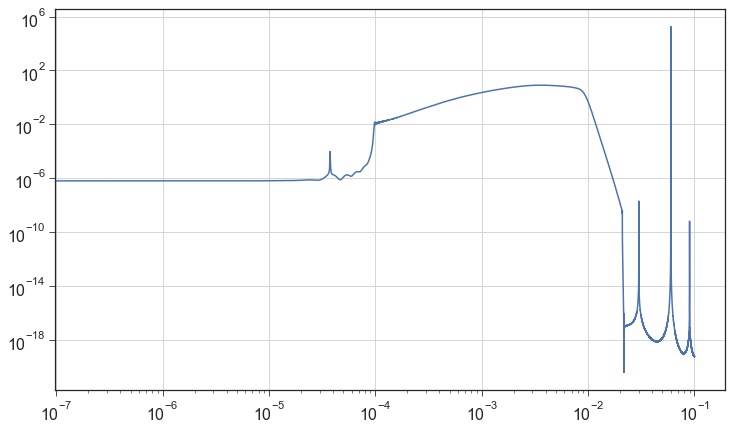

sum (450610.72716767597+0j) (671.2754480596441+0j)
range 527 89597 9.999250530557957e-05 0.017000054075643284
here (0.008928393621585333+0j) 0j
(1054080,)
check,  [0.5081708 0.5009754] [535652.16567691 528067.65254421] 1054079.0
(1054080,)


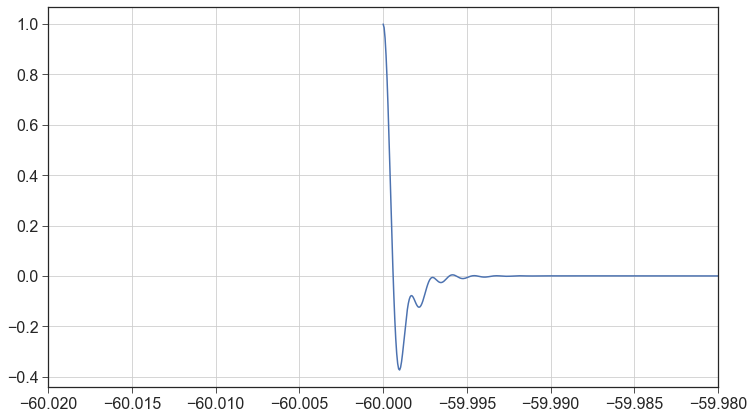

In [52]:

del_f = freq[2]-freq[1]
print ('df = ', del_f)

Nmodel = get_noise_model(noise_model, freq[:Nf])
Npsd = Nmodel.psd(freq[:Nf], option="X", tdi2=TDI2)
S = np.zeros(Nf+1)
S[:Nf] = np.copy(Npsd)
S[0] = Npsd[1]
S[Nf] = S[Nf-1]

print (freq[Nf])
freq[Nf] = np.abs(freq[Nf])
print (freq[:Nf+1])
plt.loglog(freq[:Nf+1], 4.*del_f*Xf1*np.conjugate(Xf1)/S)
# plt.loglog(freq[:Nf+1], S)
plt.show()

SN2 = 4.0*del_f*np.sum(Xf1*np.conjugate(Xf1)/S)
print ('sum', SN2, np.sqrt(SN2))


i_min = np.argwhere(freq[:Nf]<1.e-4)[-1, 0]
i_max = np.argwhere(freq[:Nf]>1.7e-2)[0, 0]
print ('range', i_min, i_max, freq[i_min], freq[i_max])



del_t = tm_loud[1]-tm_loud[0]

XXf1 = 4.0*del_f*Xf1*np.conjugate(Xf1)/S
XXf1[i_max:] = 0.0
print ('here', XXf1[i_min], XXf1[i_max])

XXt1 = np.fft.irfft(XXf1)
print (np.shape(XXt1))
print ("check, ", XXt1[:2], XXt1[:2]*T_loud/del_t, T_loud/del_t)

XXf2 = Xf2*np.conjugate(Xf2)
XXt2 = np.fft.ifft(XXf2)
print (np.shape(XXt2))

plt.plot(tm_loud/day, XXt1/XXt1[0])
# plt.plot(tm_loud/day, XXt2, '.')
# plt.xlim(0.95,1.05)
plt.xlim(-60.02,-59.98)
plt.show()


### data with glitch

tc =  133.41371437360257
(1054080,)
0.9999421296296269 0.9999430338048411
tm_glitch [-22.1        -22.09994213 -22.09988426 ...   0.99982639   0.99988426
   0.99994213]
X glitch [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.88761232e-34
  1.17910836e-33  2.14164580e-33]
(1054080,) 399168
(399168,)


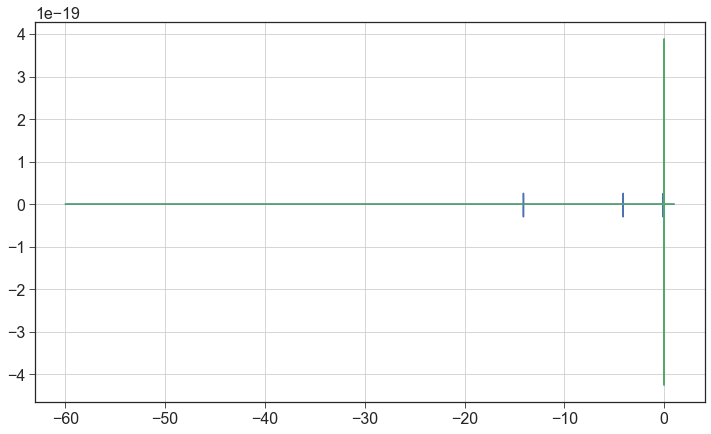

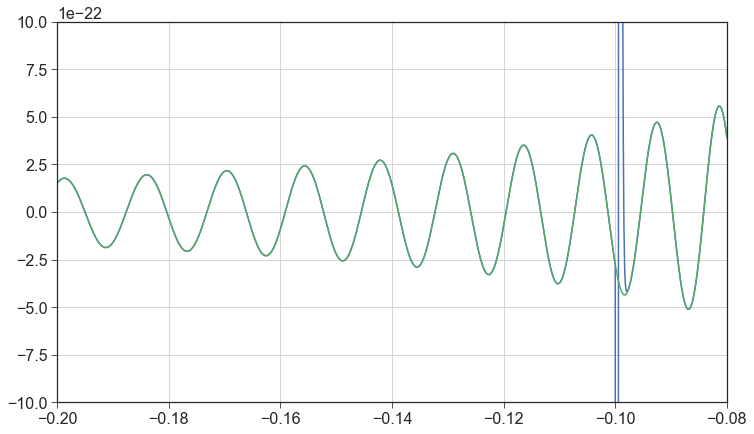

In [53]:

ind = 0

X = mbhb_fast[ind]

pars = mbhb_cat[ind]
tc = pars['CoalescenceTime']
print ('tc = ', tc/day)

ind_s = np.argwhere(((X['t'].values - tc)/day >= -60.0) & ((X['t'].values - tc)/day <= 1.0))[:, 0]
print (np.shape(ind_s))

X_loud = X.values[ind_s]
tm_loud = X['t'].values[ind_s] - tc



# plt.plot(tm/day+7.4-30.0, X_glitch)
# plt.show()
# print (len(X_glitch), len(X_loud))

# offset = 7.9
offset = 7.9
ind_g = np.argwhere((tm/day+offset-30.0)<1.0 )[:,0]
tm_glitch = tm[ind_g]+(offset-30.0)*day
print (tm_glitch[-1]/day, tm_loud[-1]/day)
X_glitch_loud = X_glitch[ind_g]

print ('tm_glitch', tm_glitch/day)
print ('X glitch', X_glitch_loud)

N_g_l= len(X_glitch_loud)
X_s_g_loud = np.copy(X_loud)
print (np.shape(X_s_g_loud), N_g_l)
print (np.shape(X_s_g_loud[-N_g_l:]))

X_s_g_loud[-N_g_l:] =  X_s_g_loud[-N_g_l:] + X_glitch_loud


# plt.plot(tm_glitch/day, X_glitch_loud)

plt.plot(tm_loud/day, X_s_g_loud)
plt.plot(tm_loud/day, X_loud)
# plt.xlim(-0.12, -0.08)
# plt.xlim(-6, -0.08)
# plt.xlim(-0.2, -0.08)
# plt.ylim(-1e-21, 1.e-21)
plt.show()

plt.plot(tm_loud/day, X_s_g_loud)
plt.plot(tm_loud/day, X_loud)
# plt.xlim(-0.12, -0.08)
# plt.xlim(-6, -0.08)
plt.xlim(-0.2, -0.08)
plt.ylim(-1e-21, 1.e-21)
plt.show()

(1054080,) (527041,) (527041,)


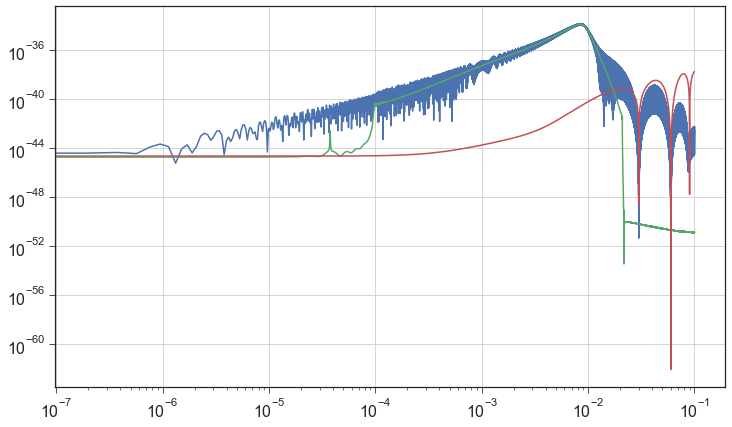

In [54]:


Xf_glitch_loud = np.fft.rfft(X_s_g_loud)

print (np.shape(X_s_g_loud), np.shape(Xf_glitch_loud), np.shape(Xf1))

fr = freq[:Nf+1]

plt.loglog(fr, np.abs(Xf_glitch_loud)**2)
plt.loglog(fr, np.abs(Xf1)**2)
plt.loglog(fr, S)
# plt.ylim(1.e-45, 1.e-37)
plt.show()

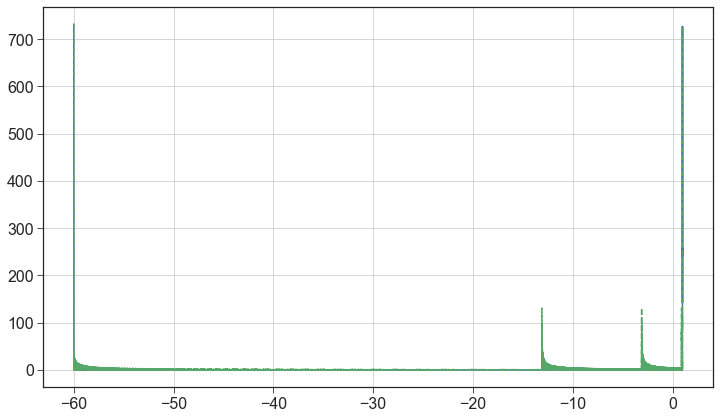

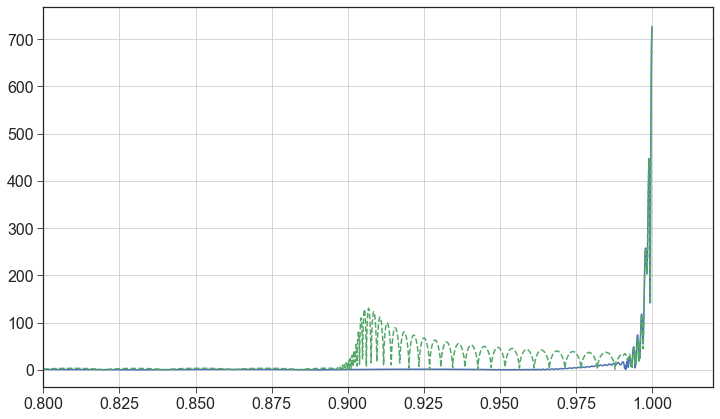

In [58]:
Nt = int(T_loud/del_t)

def Rho2(x,y,S, i_min=0, i_max=None):
    XXf1 = 4.0*del_f*x*np.conjugate(y)/S
    if (i_max is not None):
        XXf1[i_max:] = 0.0
    if (i_min > 0):
        XXf1[:i_min] = 0.0
    XXt1 = np.fft.irfft(XXf1)*Nt
#     XXt1 = XXt1/XXt1[0]
    
    return (XXt1)

tst1 = Rho2(Xf1, Xf1, S, i_min=i_min, i_max=i_max)

tst2 = Rho2(Xf_glitch_loud, Xf_glitch_loud, S, i_min=i_min, i_max=i_max)

tst3 = Rho2(Xf_glitch_loud, Xf1, S, i_min=0, i_max=i_max)


plt.plot(tm_loud/day, np.sqrt(np.abs(tst1)))
# plt.plot(tm_loud/day, tst2, '.')
plt.plot(tm_loud/day, np.sqrt(np.abs(tst3)), '--')
# plt.plot(tm_loud/day, XXt2, '.')
# plt.xlim(0.8,1.02)
# plt.xlim(-60.02,-59.98)
plt.show()


plt.plot(tm_loud/day, np.sqrt(np.abs(tst1)))
# plt.plot(tm_loud/day, tst2, '.')
plt.plot(tm_loud/day, np.sqrt(np.abs(tst3)), '--')
# plt.plot(tm_loud/day, XXt2, '.')
plt.xlim(0.8,1.02)
# plt.xlim(-60.02,-59.98)
plt.show()

    

## Look at the second glitch 

8.0
tc= 101.23250542360047


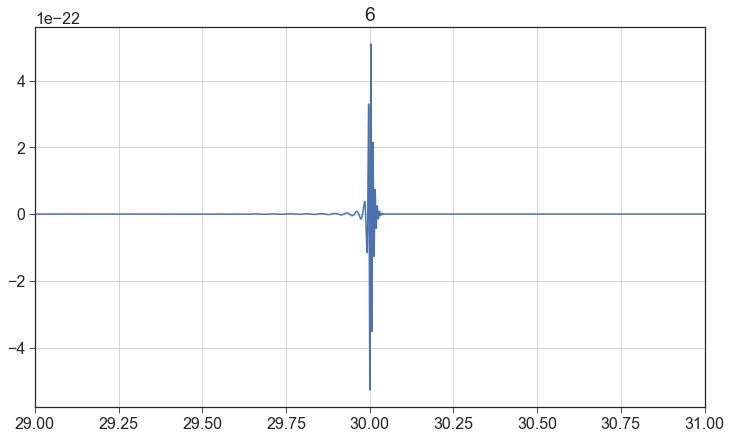

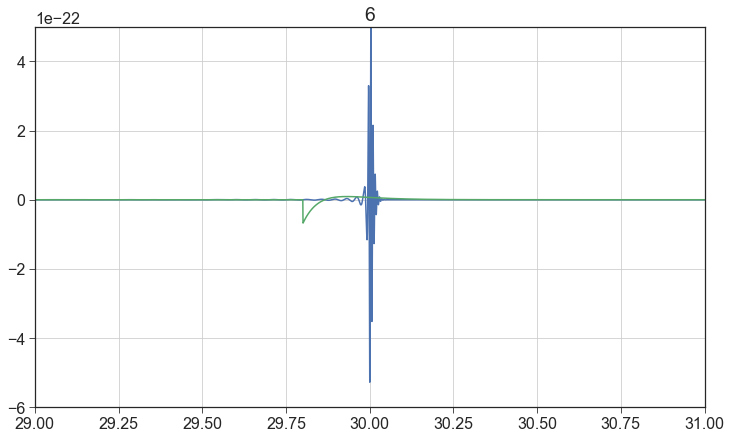

In [59]:
# ind_l = 3
# ind_l = 7
ind_l = 6

pars_l = mbhb_cat[ind_l]
tc = pars_l['CoalescenceTime']
#     print ('tc = ', tc)
X = mbhb_fast[ind_l]

tgl_l = conf_long['glitch 1 injection time']
print (tgl_l/day)

print ('tc=', tc/day)
plt.title(str(ind_l))
plt.plot((X['t'].values - tc + 30*day)/day, X.values)
# plt.plot(tm/day+21.8, X_glitch2)
plt.xlim(29, 31)
# # plt.ylim(-1.e-22, 1.e-22)
# plt.ylim(-6.e-22, 6.e-22)
# plt.grid()
plt.show()

plt.title(str(ind_l))
plt.plot((X['t'].values - tc + 30*day)/day, X.values)
# plt.plot((X['t'].values - tc + 30*day)/day, X.values)
plt.plot(tm/day+21.8, X_glitch2)
plt.xlim(29, 31)
# plt.ylim(-1.e-22, 1.e-22)
plt.ylim(-6.e-22, 5.e-22)
# plt.grid()
plt.show()

### Combining the data

(535680,)
86396.53140091896
[     0      1      2 ... 164157 164158 164159] 129595.0
size of glitch data 164160, size of the gltich 518400, signal size 535680


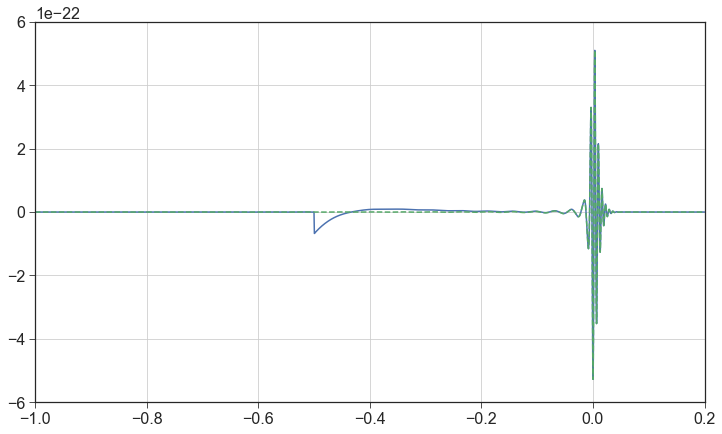

In [60]:
ind_q = np.argwhere(((X['t'].values - tc)/day >= -30.0) & ((X['t'].values - tc)/day <= 1.0))[:, 0]
print (np.shape(ind_q))

X_quiet = X.values[ind_q]
tm_quiet = X['t'].values[ind_q] - tc


print (tm_quiet[-1])
# ind_qg = np.argwhere(tm-8.02*day <= tm_quiet[-1] )[:, 0]
ind_qg = np.argwhere(tm-8.5*day <= tm_quiet[-1] )[:, 0]
print (ind_qg, tm[ind_qg[-1]]-8.0*day)
Nqg = len(ind_qg)

print (f'size of glitch data {len(ind_qg)}, size of the gltich {len(X_glitch2)}, signal size {len(X_quiet)}')

Xqg_t = np.copy(X_quiet)

Xqg_t[-Nqg:] = Xqg_t[-Nqg:] + X_glitch2[ind_qg]


plt.plot(tm_quiet/day, Xqg_t)
plt.plot(tm_quiet/day, X_quiet, '--')
# plt.plot(tm/day-8.05, X_glitch2)
plt.xlim(-1, 0.2)
plt.ylim(-6e-22, 6e-22)
plt.show()


# offset = 7.9
# plt.plot(tm/day+21.8, X_glitch2) 
# ind_g = np.argwhere((tm/day+-30.0)<1.0 )[:,0]
# tm_glitch = tm[ind_g]+(offset-30.0)*day
# print (tm_glitch[-1]/day, tm_loud[-1]/day)
# X_glitch_loud = X_glitch[ind_g]

/Users/stas/anaconda3/lib/python3.8/site-packages/ldc-0.1-py3.8-macosx-10.9-x86_64.egg/ldc/lisa/noise/noise.py:205: RuntimeWarning: divide by zero encountered in true_divide
  Sa_a = self.DSa_a[model] * (1.0 +(0.4e-3/frq)**2) *\
/Users/stas/anaconda3/lib/python3.8/site-packages/ldc-0.1-py3.8-macosx-10.9-x86_64.egg/ldc/lisa/noise/noise.py:207: RuntimeWarning: divide by zero encountered in power
  self.Sa_d = Sa_a*(2.*np.pi*frq)**(-4.) # in displacement
/Users/stas/anaconda3/lib/python3.8/site-packages/ldc-0.1-py3.8-macosx-10.9-x86_64.egg/ldc/lisa/noise/noise.py:208: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = self.Sa_d*(2.0*np.pi*frq/CLIGHT)**2 # in rel freq unit
/Users/stas/anaconda3/lib/python3.8/site-packages/ldc-0.1-py3.8-macosx-10.9-x86_64.egg/ldc/lisa/noise/noise.py:212: RuntimeWarning: divide by zero encountered in true_divide
  self.Soms_d = self.DSoms_d[model] * (1. + (2.e-3/frq)**4) # in displacement
/Users/stas/anaconda3/lib/python3.8/site-packages/ldc-0.1

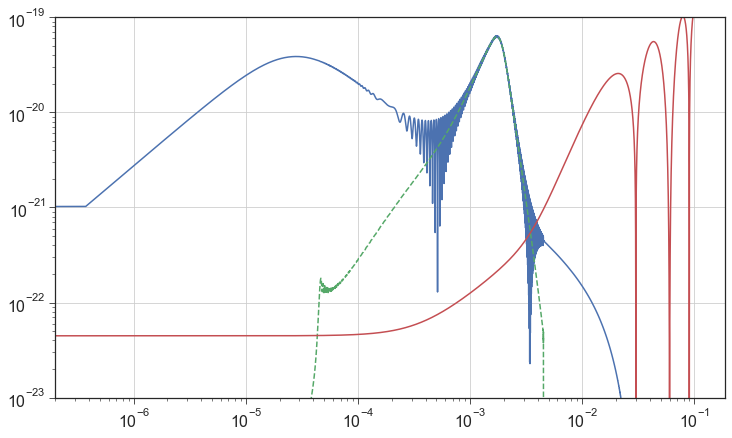

range 107 26784 3.9949297993761184e-05 0.010000018667896259


In [61]:
del_t = tm_quiet[1]-tm_quiet[0]
DT = tm_quiet[-1] - tm_quiet[0]

X_quiet_f = np.fft.rfft(X_quiet)
Xqg_f = np.fft.rfft(Xqg_t)

Nf = len(Xqg_f)
freq = np.arange(Nf)*(1./DT)
Nmodel = get_noise_model(noise_model, freq)
S = Nmodel.psd(freq, option="X", tdi2=TDI2)
S[0] = S[1]

plt.loglog(freq, np.abs(Xqg_f))
plt.loglog(freq, np.abs(X_quiet_f), '--')
plt.loglog(freq, np.sqrt(S))
plt.ylim(1.e-23, 1.e-19)
plt.show()

i_min = np.argwhere(freq<4.e-5)[-1, 0]
i_max = np.argwhere(freq[:Nf]>1.e-2)[0, 0]
print ('range', i_min, i_max, freq[i_min], freq[i_max])


SN2 543.0789180251419 SN 23.304053682248973


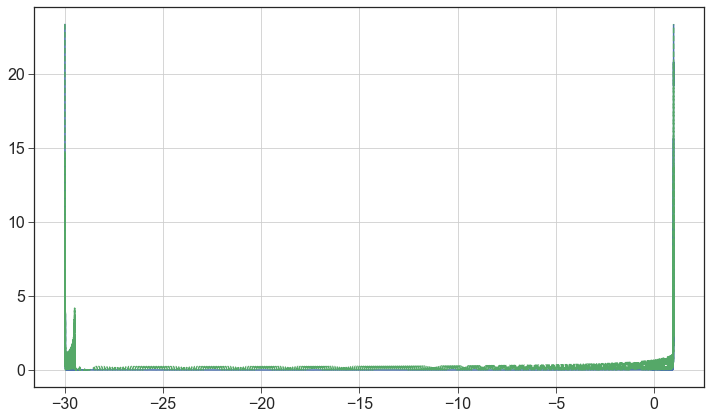

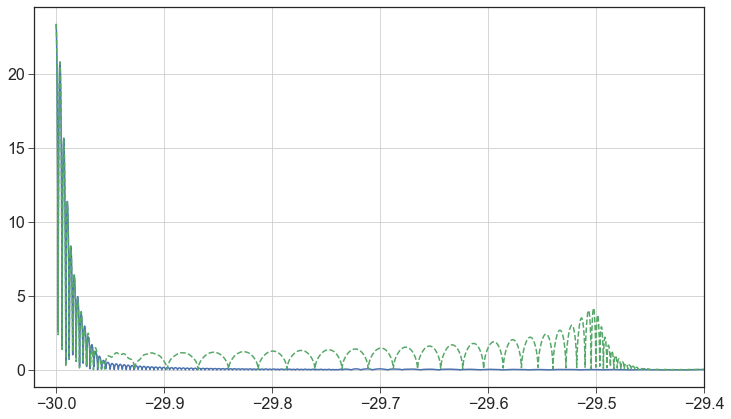

In [63]:
tst1 = Rho2(X_quiet_f, X_quiet_f, S, i_min=0, i_max=i_max)

tst2 = Rho2(Xqg_f, Xqg_f, S, i_min=0, i_max=i_max)

tst3 = Rho2(X_quiet_f, Xqg_f, S, i_min=0, i_max=i_max)

# tst2 = Rho2(Xf_glitch_loud, Xf_glitch_loud, S, i_min=i_min, i_max=i_max)

# tst3 = Rho2(Xf_glitch_loud, Xf1, S, i_min=0, i_max=i_max)

print ('SN2', tst1[-1], 'SN', np.sqrt(tst1[-1]))

plt.plot(tm_quiet/day, np.sqrt(np.abs(tst1)))
plt.plot(tm_quiet/day, np.sqrt(np.abs(tst3)),'--')

# plt.xlim(-30.02,-29.4)

plt.show()


plt.plot(tm_quiet/day, np.sqrt(np.abs(tst1)))
plt.plot(tm_quiet/day, np.sqrt(np.abs(tst3)),'--')
# plt.plot(tm_quiet/day, tst1)
# plt.plot(tm_quiet/day, tst3,'--')
# plt.xlim(0.,1.02)
# plt.xlim(-30.02,-29.8)
plt.xlim(-30.02,-29.4)
# plt.xlim(0.8,1.02)
# plt.xlim(0.8,0.9)
# plt.ylim(-100,100)
# plt.xlim(-30.02,-29.9)
plt.show()